In [8]:
#Group project DSCI 100 Group #3

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Classification of Stellar Objects

In astronomy, the classification of stars, galaxies, and quasars is fundamental towards the understanding of our own galaxy. Galaxies are large systems of stars (Greshko, 2021), whereas quasars are active galactic nuclei powered by supermassive black holes found at the center of massive galaxies (Bañados et al. 2016). The three can be hard to differentiate solely through observation as they all radiate different wavelengths, hence, astronomers use other spectral characteristics for object identification.

**Predictive Question:** Is it possible to use Sloan Digital Sky Survey (SDSS) measurements to predict whether a future stellar body of an unknown type is a star, quasar or galaxy?

The dataset used in our project contains 100,000 observations of space, each of which are classified as a star, galaxy, or quasar, based on their spectral characteristics. Every observation was taken by the SDSS and was given a unique object identifier.

**Dataset of interest:** 2017 Stellar Classification (SDSS17) https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

The variables of interest we will use in our dataset include:

* u: the ultraviolet filter in the photometric system
* g: the green filter in the photometric system
* r: the red filter in the photometric system
* i: the near Infrared filter in the photometric system
* z: the infrared filter in the photometric system
* class: the object class (galaxy, star, or quasar object)
* redshift: the redshift value based on the increase in wavelength


#### Preliminary Exploratory Data Analysis
*The cell below demonstrates reading our data into R.*

##### I. Tidying the Chosen Data Set
To tidy our data, we replaced the original column names to be more representative of the values. Then, we selected our variables of interest.

In [9]:
star_data <- read_csv("star_classification.csv")
## clean data (use tidy data criteria); 
# each row is a single observation,
# each column is a single variable, and
# each value is a single cell (i.e., its entry in the data frame is not shared with another value).

##tidying data:
star_data_tidy <- mutate(star_data, ascension_angle = alpha, declination_angle = delta,
                        ultraviolet_filter = u, green_filter = g, red_filter = r,
                        near_infrared_filter = i, infrared_filter = z, class = as.factor(class))

star_data_tidy <- select(star_data_tidy, ascension_angle, declination_angle, ultraviolet_filter, green_filter, 
                          red_filter, near_infrared_filter, infrared_filter, redshift, class)



Rows: 100000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): class
dbl (17): obj_ID, alpha, delta, u, g, r, i, z, run_ID, rerun_ID, cam_col, fi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### II. Summary of Training Data

In [13]:

count <- star_data_tidy |> 
         group_by(class) |>
         summarize(count = n())

star_counts_plot <- ggplot(count, aes(x = class, y = count, fill = class)) + 
   geom_bar(stat = "identity") +
    labs(x = "Type of Stellar Body", fill = "Type of Stellar Body", y = "Count") + 
    theme(text = element_text(size = 15)) +
    ggtitle("Figure 1.0 Stellar Body Type Counts")

#sampling from data to make data balanced
star_data_star <- star_data_tidy |>
                  filter(class == "STAR") |>
                  sample_n(1000)

star_data_galaxy <- star_data_tidy |>
                  filter(class == "GALAXY") |>
                  sample_n(1000)

star_data_qso <- star_data_tidy |>
                  filter(class == "QSO") |>
                  sample_n(1000)

star_data_balanced <- rbind(star_data_qso, star_data_galaxy, star_data_star) |>
                  sample_n(1000)

#Split Train and Testing data
star_split <- initial_split(star_data_balanced, prop = 0.75, strata = class)
star_training <- training(star_split)
star_testing <- testing(star_split)

star_table <- star_training |>
              group_by(class) |>
              summarize(mean_ascension_angle = mean(ascension_angle), mean_declination_angle = mean(declination_angle),
                        mean_ultraviolet_filter = mean(ultraviolet_filter), mean_green_filter = mean(green_filter),
                        mean_red_filter = mean(red_filter), mean_near_infrared_filter = mean(near_infrared_filter), mean_infrared_filter = mean(infrared_filter),
                        mean_infrared_filter = mean(infrared_filter), mean_redshift = mean(redshift), number_of_stellar_type = n())
star_table


class,mean_ascension_angle,mean_declination_angle,mean_ultraviolet_filter,mean_green_filter,mean_red_filter,mean_near_infrared_filter,mean_infrared_filter,mean_redshift,number_of_stellar_type
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GALAXY,184.0196,24.83801,22.48783,20.93533,19.61793,18.85748,18.44615,0.4255446453,242
QSO,181.0588,24.89872,21.60384,20.95993,20.58627,20.42197,20.26676,1.7852092540,261
STAR,181.2151,23.45812,21.36143,19.85037,19.17792,18.77604,18.50234,-0.0001189732,246


,ascension_angle,declination_angle,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,redshift
ascension_angle,1.00000000,0.11508506,0.00573982,-0.01768611,-0.01468895,-0.01798189,-0.01510383,-0.01462335
declination_angle,0.11508506,1.00000000,-0.03324798,-0.01532488,-0.02186108,-0.03813436,-0.03872453,0.02130872
ultraviolet_filter,0.00573982,-0.03324798,1.00000000,0.84898406,0.70598298,0.59419006,0.50979692,0.17731044
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
near_infrared_filter,-0.01798189,-0.03813436,0.5941901,0.8366938,0.9370045,1.0000000,0.9561694,0.4642125
infrared_filter,-0.01510383,-0.03872453,0.5097969,0.7454017,0.8774010,0.9561694,1.0000000,0.4742518
redshift,-0.01462335,0.02130872,0.1773104,0.2989814,0.3615578,0.4642125,0.4742518,1.0000000


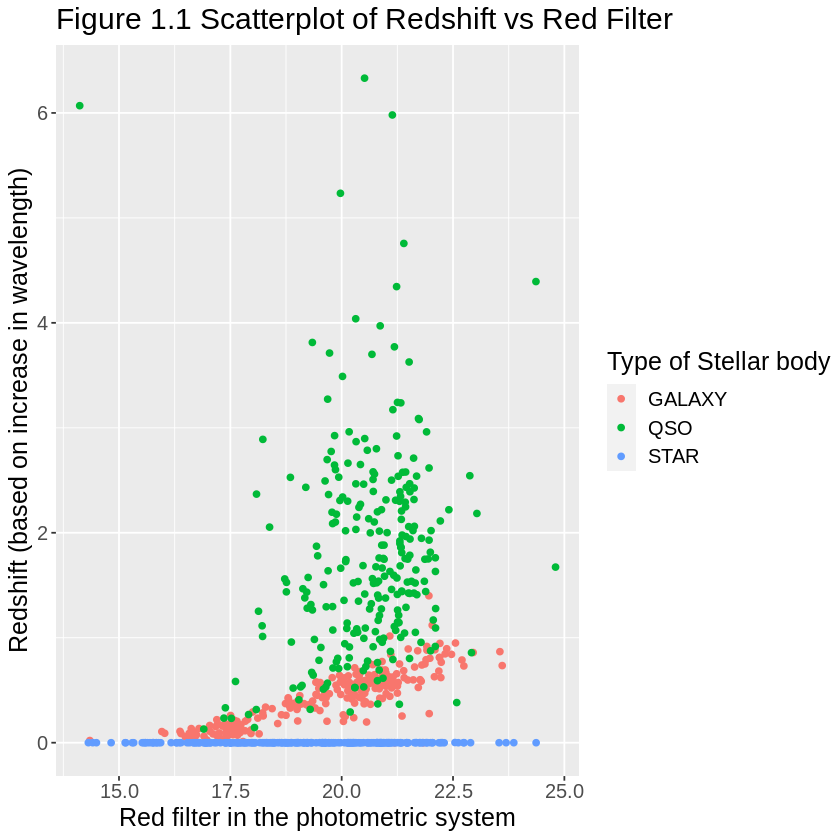

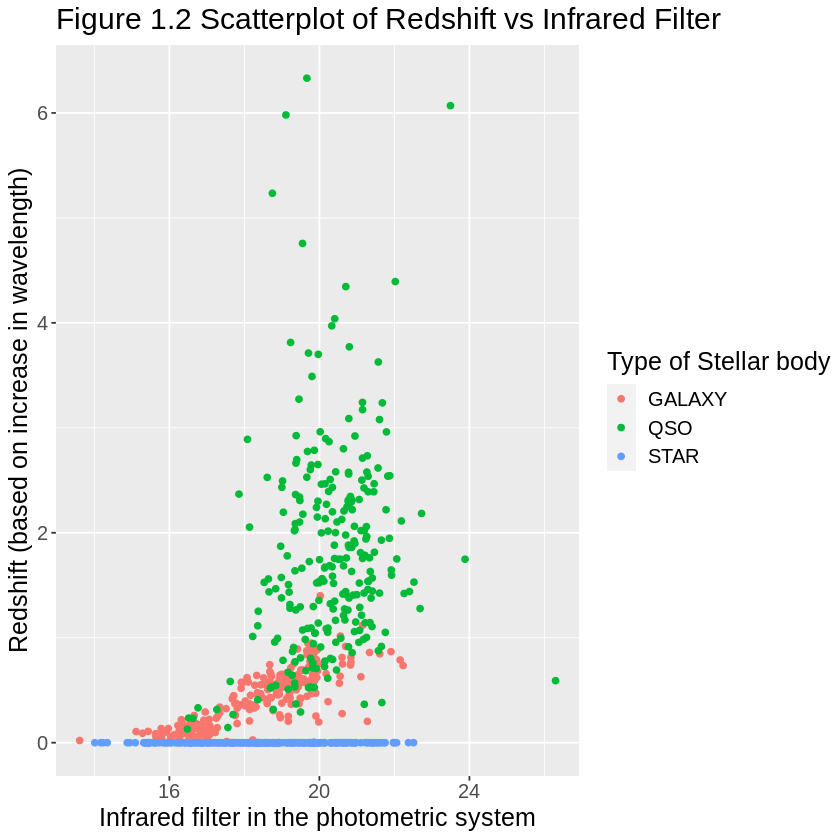

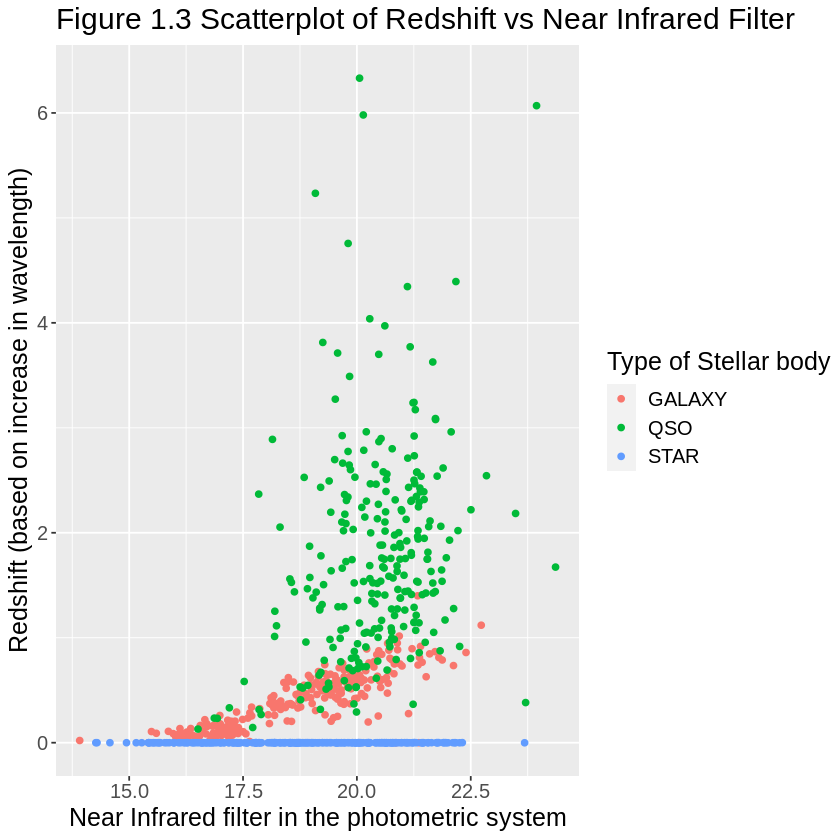

In [15]:
# correlation between variables
cor(select(star_training, -class))

(redshift_vs_red_filter <- ggplot(star_training, aes(y = redshift, x = red_filter, color = class)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Red filter in the photometric system", color = "Type of Stellar body") +
                            theme(text = element_text(size = 15)) +
                            ggtitle("Figure 1.1 Scatterplot of Redshift vs Red Filter"))

(redshift_vs_infrared <- ggplot(star_training, aes(y = redshift, x = infrared_filter, color = class)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Infrared filter in the photometric system", color = "Type of Stellar body") +
                            theme(text = element_text(size = 15)) +
                            ggtitle("Figure 1.2 Scatterplot of Redshift vs Infrared Filter"))
(redshift_vs_near_infrared <- ggplot(star_training, aes(y = redshift, x = near_infrared_filter, color = class)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Near Infrared filter in the photometric system", color = "Type of Stellar body") +
                            theme(text = element_text(size = 15)) +
                            ggtitle("Figure 1.3 Scatterplot of Redshift vs Near Infrared Filter"))


#### Methods

The variables we will use to predict the type of stellar body of a new observation are the ascension angle, declination angle, ultraviolet filter,  green filter, red filter, near infrared filter, infrared filter, and redshift. In previous astronomical literature and classification models, many of these factors have been demonstrated to correlate with stellar body type, and may contribute to classifying an astronomical event of type galaxy, quasar or star (Finlay-Freundlich, 1954; Wierzbiński et al. 2021; Simet et al. 2021). In our analysis, we will perform a classification using K-nearest neighbors to predict whether a new observation is of class galaxy, quasar or star, using past observations of known classes. Prior to the preprocessing of our training data, we will standardize our training data by performing scaling and centering on it so that the scales of the predictors do not unevenly impact the model. 


#### Expected outcomes and significance:

We expect to find an accurate, and runtime-efficient classification model which predicts whether a new observation detected using the SDSS telescope is a star, galaxy or quasar using its spectral properties (used as predictors above in our method).

With emerging advancements in interstellar detection and space technology, it often becomes cumbersome to classify new observations manually. Our classification model serves to tackle that issue. Our model would eventually present a more feasible and efficient approach to making forecasted predictions about the object in question and can be used side-by-side with image detection in object identification. Oftentimes, the images can be misleading hence our model would aim to provide more clarity in such circumstances. Ultimately, it also saves astronomers’ time!

In astronomy, there is always room for new objects to be discovered. Since 95% of our solar system is made up of dark matter which has not been observed as of yet, it is highly likely that there exist objects which we know very little of. Our model serves as a stepping stone into that research to make educated guesses about dark matter and what objects, even though unobservable, they could most likely behave as. It could also lead into questions about the origins of these objects, how they are associated with each other and ultimately help us answer the big, boiling questions about the Universe. 


### Works Cited

Bañados, E.,  Venemans, B. P., Decarli, R., Farina, E. P., Mazzucchelli, C., Walter, F.,  Fan, X.,  Stern, D., Schlafly, E., Chambers, K. C., Rix, H-W.,  Jiang, L., McGreer, I., Simcoe, R., Wang, F., Yang, J., Morganson, E., De Rosa, G., Greiner, J., …Q. Yang. (2016). THE PAN-STARRS1 DISTANT z > 5.6 QUASAR SURVEY: MORE THAN 100 QUASARS WITHIN THE FIRST GYR OF THE UNIVERSE. The American Astronomical Society. 227(1). doi: 10.3847/0067-0049/227/1/11

Becker, I., Pichara, K., Catelan, M., Protopapas, P., Aguirre, C., & Nikzat, F. (2020). Scalable end-to-end recurrent neural network for variable star classification. Monthly Notices of the Royal Astronomical Society, 493(2), 2981-2995.

Finlay-Freundlich, E. (1954). Red-shifts in the spectra of celestial bodies. Proceedings of the Physical Society. Section A, 67(2), 192.

Greshko, M. (2021, May 4). Galaxy Information and facts. Science. Retrieved March 11, 2023, from https://www.nationalgeographic.com/science/article/galaxies 

Grier, A.J, & Rivkin, A.S. (2019). Airless Bodies of the Inner Solar System. Understanding the Process Affecting Rocky, Airless Surfaces. Chapter 4, 47-94

Simet, M., Chartab, N., Lu, Y., & Mobasher, B. (2021). Comparison of observed galaxy properties with semianalytic model predictions using machine learning. The Astrophysical Journal, 908(1), 47.

Swinburne University of Technology. (n.d.). Epoch: Cosmos. Epoch | COSMOS. Retrieved March 11, 2023, from https://astronomy.swin.edu.au/cosmos/e/epoch 

The European Space Agency. (n.d.). What is 'red shift'? ESA. url: https://www.esa.int/Science_Exploration/Space_Science/What_is_red_shift 

Wierzbiński, M., Pławiak, P., Hammad, M., & Acharya, U. R. (2021). Development of accurate classification of heavenly bodies using novel machine learning techniques. Soft Computing, 25(10), 7213-7228.



